# <center> Предсказание продолжительности поездки на такси в Нью-Йорке

## 1. Постановка задачи

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача :** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.



## 2. Знакомство с данными, базовый анализ и расширение данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

Прочитаем наш файл с исходными данными:

In [ ]:
data = pd.read_csv("train.csv")
print('Train data shape: {}'.format(data.shape))
data.head()

Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу.

In [ ]:
# смотрим временные рамки данных
data['pickup_datetime']=pd.to_datetime(data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
data['pickup_datetime'].describe()

In [6]:
data['dropoff_datetime']=pd.to_datetime(data['dropoff_datetime'],format='%Y-%m-%d %H:%M:%S')

In [ ]:
# пропуски в данных
data.isnull().sum()

In [ ]:
# количество уникальных таксопарков
data['vendor_id'].unique()

In [ ]:
# максимальное количество пассажиров
data['passenger_count'].max()

In [ ]:
# средняя и медианная длительность поездки
data['duration']=data['dropoff_datetime']-data['pickup_datetime']
print(data['duration'].mean().total_seconds())
print(data['duration'].median().total_seconds())
# минимальное и максимальное время поездки (в секундах)
print(data['duration'].min().total_seconds())
print(data['duration'].max().total_seconds())

Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками.


функция add_datetime_features()  принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - порядковый номер дня недели (число), в который был включен счетчик.

In [8]:
def add_datetime_features(data):
    data['pickup_date']=data['pickup_datetime'].dt.date
    data['pickup_hour']=data['pickup_datetime'].dt.hour
    data['pickup_day_of_week']=data['pickup_datetime'].dt.dayofweek
    return data

In [9]:
data=add_datetime_features(data)

In [ ]:
# среднее количество поездок в день
data.groupby('pickup_date')['pickup_datetime'].count().mean()


In [10]:
holiday_data = pd.read_csv('holiday_data.csv', sep=';')


функция add_holiday_features() принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет).




In [11]:
def add_holiday_features(data,holiday_data):
    holiday_data['date']=pd.to_datetime(holiday_data['date']).dt.date
    df_merged = pd.merge(data, holiday_data, left_on='pickup_date', right_on='date',how='left')
    df_merged['pickup_holiday'] = df_merged['date'].notna().astype(int)
    df_merged = df_merged.drop(columns=['date','day','holiday'])
    return df_merged

df_merged=add_holiday_features(data,holiday_data)

In [ ]:
# медианная длительность поездки на такси в праздничные дни
df_merged[df_merged['pickup_holiday']==1]['duration'].median().total_seconds()

функция add_osrm_features() принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.


In [13]:
osrm_data = pd.read_csv('osrm_data_train.csv')

In [14]:
def add_osrm_features(df_merged,osrm_data):
    osrm_data=osrm_data[['id','total_distance','total_travel_time','number_of_steps']]
    data=pd.merge(df_merged,osrm_data, on='id',how='left')
    return data
data=add_osrm_features(df_merged,osrm_data)

In [ ]:
# разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM
data['duration'].median().total_seconds()-data['total_travel_time'].median()

функция add_geographical_features() принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.



In [15]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

In [16]:
def add_geographical_features(data):
    data['haversine_distance']=get_haversine_distance(data['pickup_latitude'],data['pickup_longitude'],data['dropoff_latitude'], data['dropoff_longitude'])
    data['direction']=get_angle_direction(data['pickup_latitude'],data['pickup_longitude'],data['dropoff_latitude'], data['dropoff_longitude'])
    return data

In [17]:
data=add_geographical_features(data)

In [ ]:
# медианное расстояние Хаверсина поездок (в киллометрах)
data['haversine_distance'].median()

функция add_cluster_features() принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.




In [ ]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((data[['pickup_latitude', 'pickup_longitude']],
                    data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

In [19]:
def add_cluster_features(data,kmeans):
    data['geo_cluster']=kmeans.predict(coords)
    return data

data=add_cluster_features(data,kmeans)

In [ ]:
# количество поездок по кластерам
data['geo_cluster'].value_counts()

функция add_weather_features() принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

In [20]:
weather_data = pd.read_csv('weather_data.csv')

In [21]:
def add_weather_features(data,weather_data):
    weather_data=weather_data[['time','temperature','visibility','wind speed','precip','events']].copy()
    weather_data['date']=pd.to_datetime(weather_data['time']).dt.date
    weather_data['hour']=pd.to_datetime(weather_data['time']).dt.hour
    data_mg=pd.merge(data,weather_data, left_on=['pickup_date','pickup_hour'], right_on=['date','hour'],how='left')
    data=data_mg.drop(['time','date','hour'],axis=1)
    return data

data=add_weather_features(data,weather_data)

In [ ]:
# процент пропусков в столбце погодные условия
data.isna().sum()['events']/data.shape[0]*100

 функция fill_null_weather_data() принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

In [22]:
def fill_null_weather_data(data):
    cols=['temperature','visibility','wind speed','precip']
    for col in cols:
        data[col] = data[col].fillna(
    data.groupby('pickup_date')[col].transform('median')
)
    data['events'] = data['events'].fillna('None')
    cols = ['total_distance', 'total_travel_time', 'number_of_steps']  # список нужных столбцов
    medians = data[cols].median()    # вычисляем медианы по этим столбцам
    data[cols] = data[cols].fillna(medians)
    return data

In [23]:
data=fill_null_weather_data(data)

In [ ]:
# медиана в столбце temperature после заполнения пропусков
data['temperature'].median()

В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки.

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа.

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды.
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом:
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


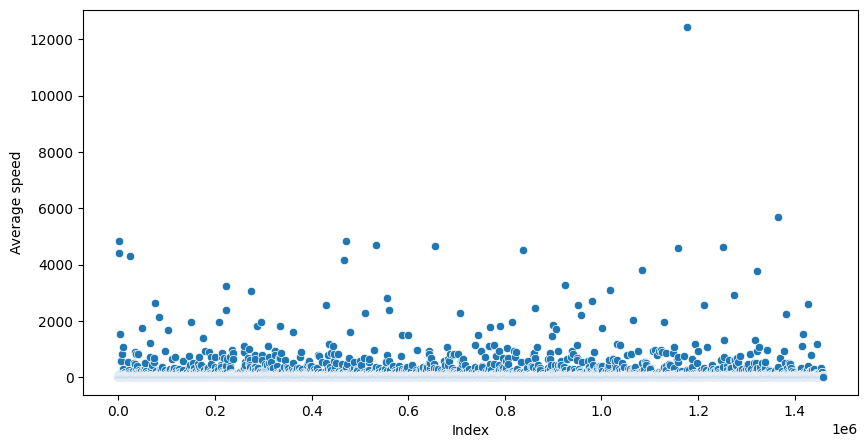

In [ ]:
avg_speed = data['total_distance'] / data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч!

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч.


In [ ]:
data['trip_dur_hour']=data['trip_duration']/3600
# находим  поездки, длительность которых превышает 24 часа
data=data.drop(data[data['trip_dur_hour']>24].index)

# находим поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч
data['avg_speed'] = data['total_distance'] / data['trip_duration']* 3.6
data=data.drop(data[data['avg_speed']>300].index)

# удаляем лишние столбцы
data=data.drop(['trip_dur_hour','avg_speed'],axis=1)

## 3. Разведывательный анализ данных (EDA)

Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [ ]:
data['trip_duration_log'] = np.log(data['trip_duration']+1)

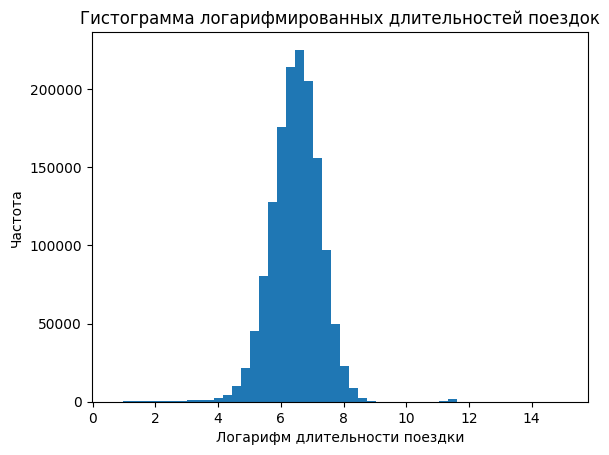

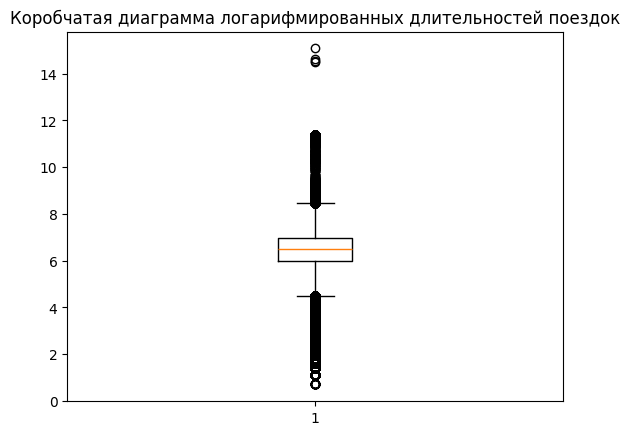

In [ ]:
# гистограмма и коробчатая диаграмма длительности поездок в логарифмическом масштабе (trip_duration_log)
plt.hist(data['trip_duration_log'], bins=50)
plt.xlabel('Логарифм длительности поездки')
plt.ylabel('Частота')
plt.title('Гистограмма логарифмированных длительностей поездок')
plt.show()

plt.boxplot(data['trip_duration_log'])
plt.title('Коробчатая диаграмма логарифмированных длительностей поездок')
plt.show()


Проверяем является ли распределение нормальным с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$.

In [ ]:
from scipy.stats import normaltest

data_log = data['trip_duration_log']
stat, p = normaltest(data_log)

print(f"Статистика теста: {stat:.4f}")
print(f"p-значение: {p:.4f}")

alpha = 0.05
if p < alpha:
    print("Распределение НЕ является нормальным на уровне значимости 0.05")
else:
    print("Распределение можно считать нормальным на уровне значимости 0.05")


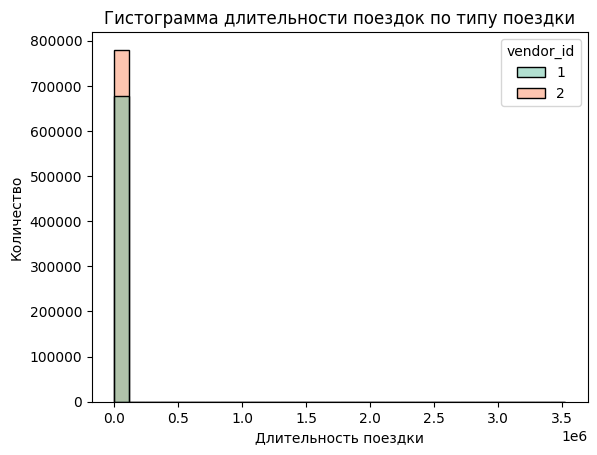

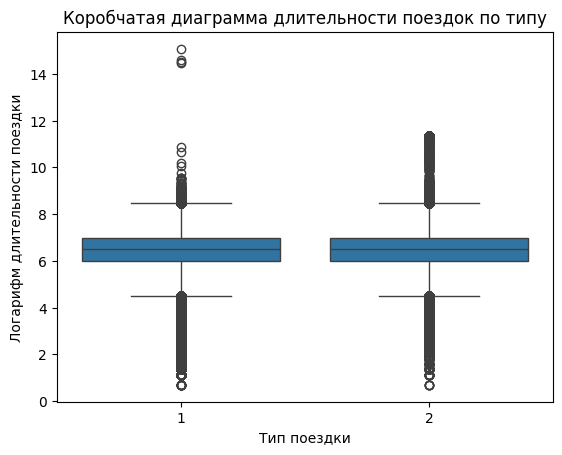

In [ ]:
# распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id)
import seaborn as sns

sns.histplot(data=data, x='trip_duration', hue='vendor_id', bins=30, kde=False, palette='Set2')

plt.xlabel('Длительность поездки')
plt.ylabel('Количество')
plt.title('Гистограмма длительности поездок по типу поездки')
plt.show()

sns.boxplot(x='vendor_id', y='trip_duration_log', data=data)

plt.xlabel('Тип поездки')
plt.ylabel('Логарифм длительности поездки')
plt.title('Коробчатая диаграмма длительности поездок по типу')

plt.show()

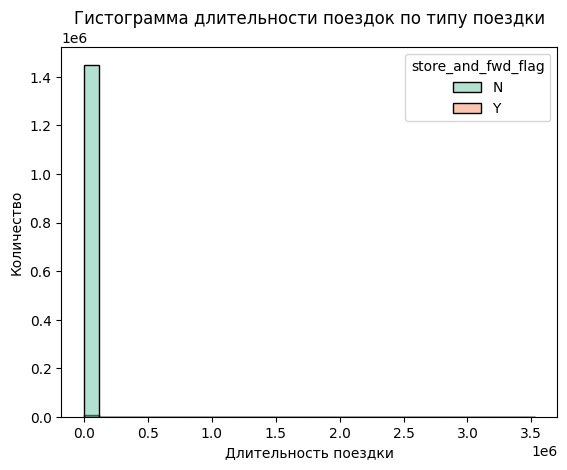

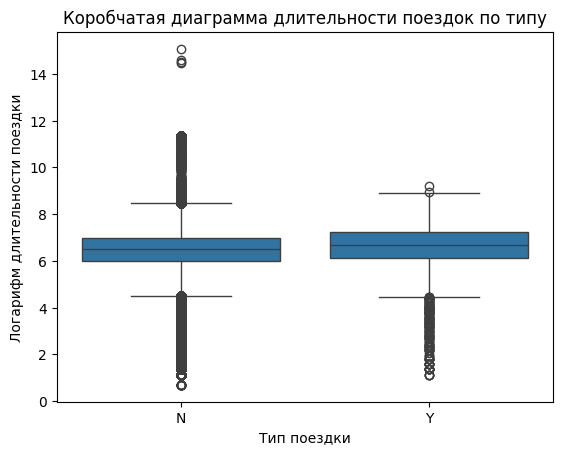

In [ ]:
# распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag)
import seaborn as sns

sns.histplot(data=data, x='trip_duration', hue='store_and_fwd_flag', bins=30, kde=False, palette='Set2')

plt.xlabel('Длительность поездки')
plt.ylabel('Количество')
plt.title('Гистограмма длительности поездок по типу поездки')
plt.show()

sns.boxplot(x='store_and_fwd_flag', y='trip_duration_log', data=data)

plt.xlabel('Тип поездки')
plt.ylabel('Логарифм длительности поездки')
plt.title('Коробчатая диаграмма длительности поездок по типу')

plt.show()

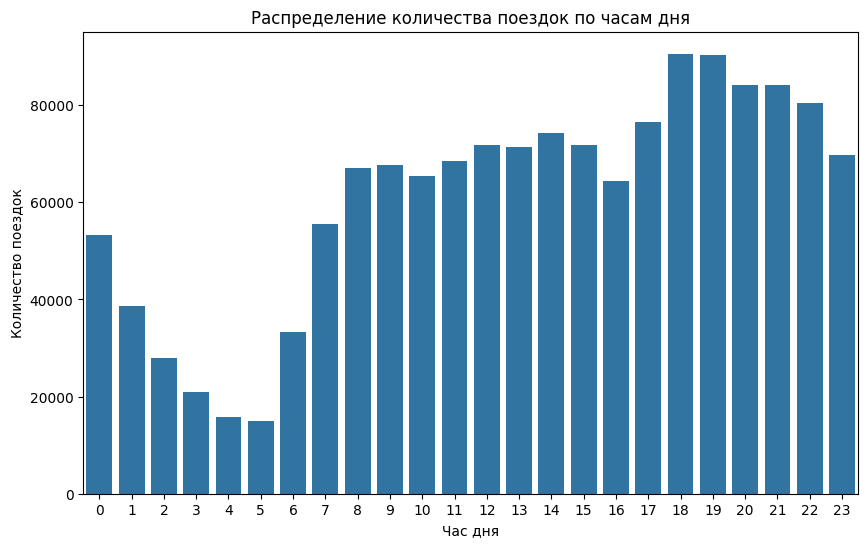

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(data=data, x='pickup_hour')
plt.xlabel('Час дня')
plt.ylabel('Количество поездок')
plt.title('Распределение количества поездок по часам дня')
plt.show()


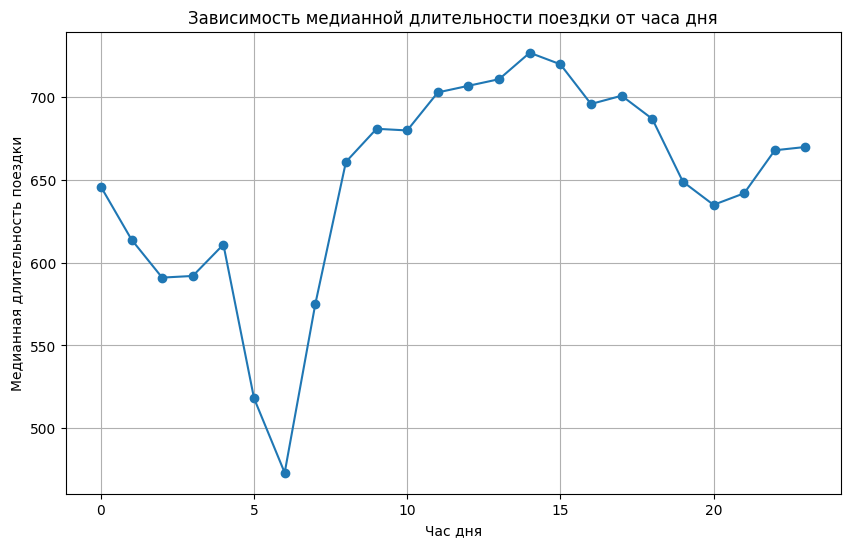

In [ ]:
data_dur=data.groupby('pickup_hour')['trip_duration'].median()


plt.figure(figsize=(10,6))
data_dur.plot(kind='line', marker='o')
plt.xlabel('Час дня')
plt.ylabel('Медианная длительность поездки')
plt.title('Зависимость медианной длительности поездки от часа дня')
plt.grid(True)
plt.show()

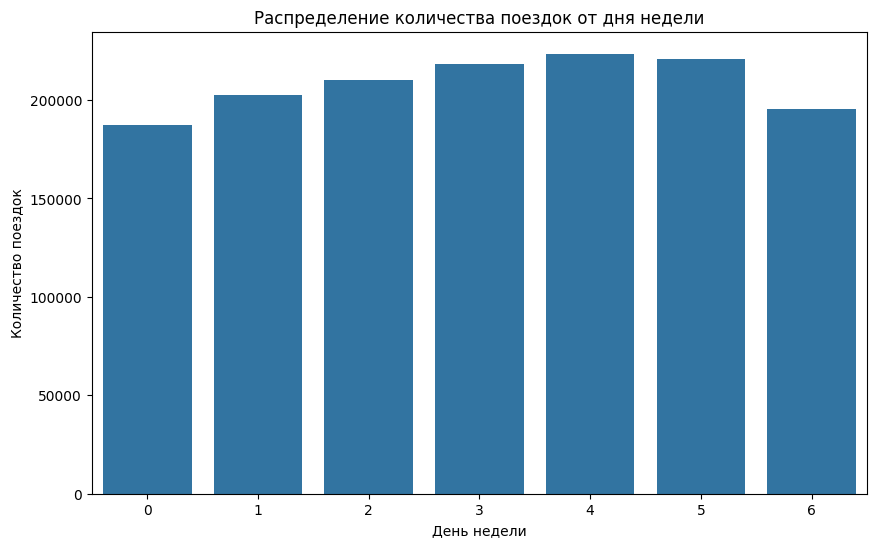

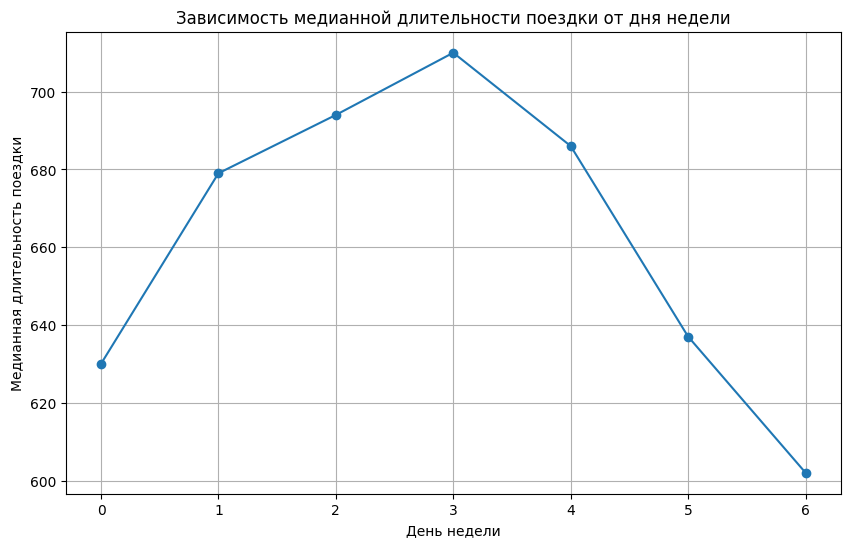

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(data=data, x='pickup_day_of_week')
plt.xlabel('День недели')
plt.ylabel('Количество поездок')
plt.title('Распределение количества поездок от дня недели')
plt.show()

data_dur=data.groupby('pickup_day_of_week')['trip_duration'].median()


plt.figure(figsize=(10,6))
data_dur.plot(kind='line', marker='o')
plt.xlabel('День недели')
plt.ylabel('Медианная длительность поездки')
plt.title('Зависимость медианной длительности поездки от дня недели')
plt.grid(True)
plt.show()


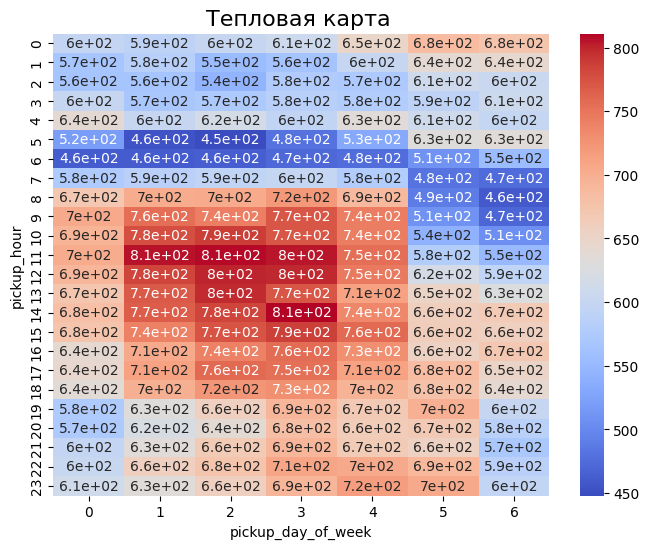

In [ ]:
pivot = data.pivot_table(
    values= 'trip_duration',
    index= 'pickup_hour',
    columns= 'pickup_day_of_week',
    aggfunc= 'median',
    fill_value=0
)

heatmap = plt.subplots(figsize=(8, 6))
heatmap = sns.heatmap(data=pivot, cmap='coolwarm', annot=True)
heatmap.set_title('Тепловая карта ', fontsize=16);

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude)
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude).
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:

city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее.

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


C:\Users\l340\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\l340\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


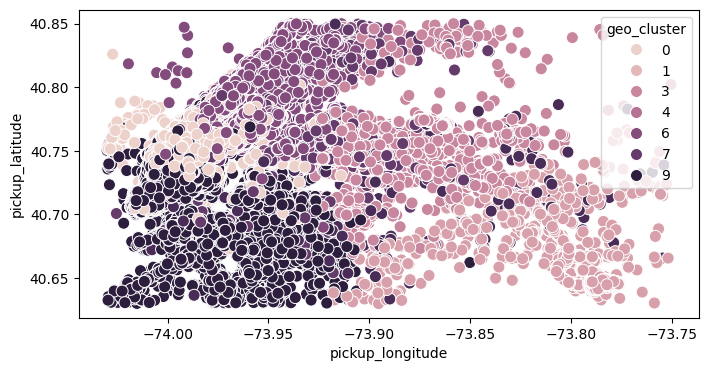

In [ ]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)


df_nyc = data[
    (data['pickup_longitude'] >= city_long_border[0]) & (data['pickup_longitude'] <= city_long_border[1]) &
    (data['pickup_latitude'] >= city_lat_border[0]) & (data['pickup_latitude'] <= city_lat_border[1])
]
# географическое расположение точек начала поездок (pickup_longitude, pickup_latitude)
fig = plt.figure(figsize=(8, 4))


scatterplot = sns.scatterplot(
    data=df_nyc,
    x='pickup_longitude',
    y='pickup_latitude',
    s=75,
    marker='o',
    hue = 'geo_cluster'
);

C:\Users\l340\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\l340\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


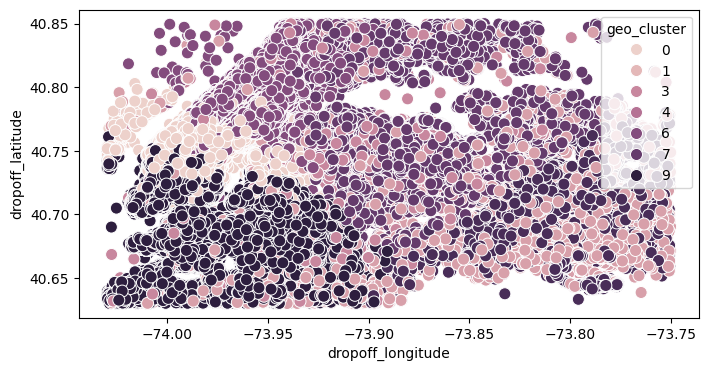

In [ ]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)


df_nyc = data[
    (data['dropoff_longitude'] >= city_long_border[0]) & (data['dropoff_longitude'] <= city_long_border[1]) &
    (data['dropoff_latitude'] >= city_lat_border[0]) & (data['dropoff_latitude'] <= city_lat_border[1])
]
# географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude)
fig = plt.figure(figsize=(8, 4))


scatterplot = sns.scatterplot(
    data=df_nyc,
    x='dropoff_longitude',
    y='dropoff_latitude',
    s=75,
    marker='o',
    hue = 'geo_cluster'
);

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [24]:
data=data.drop('duration',axis=1)

In [ ]:
print('Shape of data: {}'.format(data.shape))
print('Columns: {}'.format(data.columns))

Для удобства работы сделаем копию исходной таблицы с поездками:

In [26]:
train_data = data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,164.9,5.0,1.498521,99.970196,2,4.4,8.0,27.8,0.3,None
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,332.0,6.0,1.805507,-117.153768,9,28.9,16.1,7.4,0.0,None
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,767.6,16.0,6.385098,-159.680165,9,-6.7,16.1,24.1,0.0,None
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,235.8,4.0,1.485498,-172.737700,9,7.2,16.1,25.9,0.0,None
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,140.1,5.0,1.188588,179.473585,4,9.4,16.1,9.3,0.0,None


In [ ]:
train_data =train_data.drop(['id','dropoff_datetime'],axis=1)
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

In [28]:
# кодируем: 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.
train_data['vendor_id']=train_data['vendor_id'].apply(lambda x: 0 if x==1 else 1)

In [29]:
# кодируем: 0, если флаг выставлен в значение 'N', и 1 — в противном случае.
train_data['store_and_fwd_flag']=train_data['store_and_fwd_flag'].apply(lambda x: 0 if x=='N' else 1)

In [30]:
from sklearn.preprocessing import OneHotEncoder # импорт для работы с кодировщиком

cols_to_encode = ['pickup_day_of_week', 'geo_cluster', 'events']
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore',sparse_output=False)
# Получаем закодированные имена столбцов
data_onehot=one_hot_encoder .fit_transform(data[cols_to_encode])
column_names = one_hot_encoder.get_feature_names_out(cols_to_encode)
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)

In [ ]:
data_onehot.count()

Добавим полученную таблицу с закодированными признаками:

In [ ]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(cols_to_encode, axis=1), data_onehot],
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

In [32]:
train_data['trip_duration_log'] = np.log(data['trip_duration']+1)

In [33]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log.

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [34]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log,
    test_size=0.33,
    random_state=42
)

In [35]:
# С помощью SelectKBest отбираем 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(f_regression, k=25)
selector.fit(X_train, y_train_log)

selected_cols = X_train.columns[selector.get_support()]

# Трансформируем данные, чтобы оставить только лучшие признаки
X_train = selector.transform(X_train)
X_valid = selector.transform(X_valid)


# Отбираем столбцы исходного DataFrame по маске
X_train = pd.DataFrame(X_train, columns=selected_cols)
X_valid = pd.DataFrame(X_valid, columns=selected_cols)


In [36]:
# Нормализуем предикторы в обучающей и валидационной выборках с помощью MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

numeric_cols = X_train.select_dtypes(include=np.number).columns
X_train_numeric = X_train[numeric_cols]
X_val_numeric = X_valid[numeric_cols]

scaler.fit(X_train_numeric)
X_train_scaled = scaler.transform(X_train_numeric)
X_val_scaled = scaler.transform(X_val_numeric)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_valid.columns)

## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем  использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе



In [ ]:
#Создаём объект класса LinearRegression
lr_full = linear_model.LinearRegression()
#Обучаем модель — ищем параметры по МНК
lr_full.fit(X_train_scaled_df, y_train_log)

# Предсказание (логарифмы)
y_train_predict_log = lr_full.predict(X_train_scaled_df)
y_val_predict_log = lr_full.predict(X_val_scaled_df)

# Обратное преобразование в исходную шкалу
y_train_orig = np.expm1(y_train_log)
y_val_orig = np.expm1(y_valid_log)

y_train_predict = np.expm1(y_train_predict_log)
y_val_predict = np.expm1(y_val_predict_log)

# Защита от отрицательных предсказаний
y_train_predict = np.maximum(y_train_predict, 0)
y_val_predict = np.maximum(y_val_predict, 0)

print("RMSLE на тренировочной выборке : {:.2f}".format(metrics.root_mean_squared_log_error(y_train_orig, y_train_predict)))
print("RMSLE на тестовой выборке: {:.2f}".format(metrics.root_mean_squared_log_error(y_val_orig, y_val_predict)))



RMSLE на тренировочной выборке : 0.54
RMSLE на тестовой выборке: 0.54


In [ ]:
#Создаём объект класса DecisionTreeRegressor
dt_r = tree.DecisionTreeRegressor(random_state=42,max_depth=10)

#Обучаем дерево решений по алгоритму CART
dt_r.fit(X_train_scaled_df, y_train_log)

# Предсказание (логарифмы)
y_train_predict_log = dt_r.predict(X_train_scaled_df)
y_val_predict_log = dt_r.predict(X_val_scaled_df)

# Обратное преобразование в исходную шкалу
y_train_orig = np.expm1(y_train_log)
y_val_orig = np.expm1(y_valid_log)

y_train_predict = np.expm1(y_train_predict_log)
y_val_predict = np.expm1(y_val_predict_log)

# Защита от отрицательных предсказаний
y_train_predict = np.maximum(y_train_predict, 0)
y_val_predict = np.maximum(y_val_predict, 0)

print("RMSLE на тренировочной выборке: {:.2f}".format(metrics.root_mean_squared_log_error(y_train_orig, y_train_predict)))
print("RMSLE на тестовой выборке: {:.2f}".format(metrics.root_mean_squared_log_error(y_val_orig, y_val_predict)))


RMSLE на тренировочной выборке: 0.43
RMSLE на тестовой выборке: 0.43


In [ ]:
# #Создаём объект класса DecisionTreeRegressor
dt_r = tree.DecisionTreeRegressor(random_state=42,max_depth=12)

#Обучаем дерево решений по алгоритму CART
dt_r.fit(X_train_scaled_df, y_train_log)

# Предсказание (логарифмы)
y_train_predict_log = dt_r.predict(X_train_scaled_df)
y_val_predict_log = dt_r.predict(X_val_scaled_df)

# Обратное преобразование в исходную шкалу
y_train_orig = np.expm1(y_train_log)
y_val_orig = np.expm1(y_valid_log)

y_train_predict = np.expm1(y_train_predict_log)
y_val_predict = np.expm1(y_val_predict_log)

# Защита от отрицательных предсказаний
y_train_predict = np.maximum(y_train_predict, 0)
y_val_predict = np.maximum(y_val_predict, 0)

print("RMSLE на тренировочной выборке: {:.2f}".format(metrics.root_mean_squared_log_error(y_train_orig, y_train_predict)))
print("RMSLE на тестовой выборке: {:.2f}".format(metrics.root_mean_squared_log_error(y_val_orig, y_val_predict)))


RMSLE на тренировочной выборке: 0.41
RMSLE на тестовой выборке: 0.43


## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам.

In [41]:
from lightgbm import LGBMRegressor
lgb = LGBMRegressor( n_estimators=50,random_state=42,  max_depth=5,n_jobs=-1)
#Обучаем модель
lgb.fit(X_train_scaled_df, y_train_log)

# Предсказание (логарифмы)
y_train_predict_log = lgb.predict(X_train_scaled_df)
y_val_predict_log = lgb.predict(X_val_scaled_df)

# Обратное преобразование в исходную шкалу
y_train_orig = np.expm1(y_train_log)
y_val_orig = np.expm1(y_valid_log)

y_train_predict = np.expm1(y_train_predict_log)
y_val_predict = np.expm1(y_val_predict_log)

# Защита от отрицательных предсказаний
y_train_predict_lgb = np.maximum(y_train_predict, 0)
y_val_predict_lgb = np.maximum(y_val_predict, 0)

print("RMSLE на тренировочной выборке: {:.2f}".format(metrics.root_mean_squared_log_error(y_train_orig, y_train_predict_lgb)))
print("RMSLE на тестовой выборке: {:.2f}".format(metrics.root_mean_squared_log_error(y_val_orig, y_val_predict_lgb)))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2005
[LightGBM] [Info] Number of data points in the train set: 977291, number of used features: 25
[LightGBM] [Info] Start training from score 6.467065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
RMSLE на тренировочной выборке: 0.42
RMSLE на тестовой выборке: 0.42


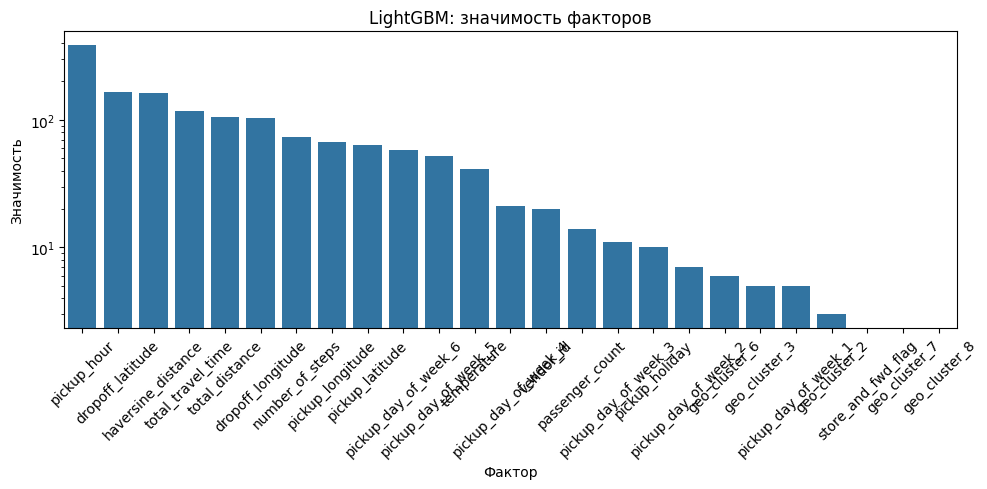

Топ-3 признака: ['pickup_hour' 'dropoff_latitude' 'haversine_distance']


In [43]:
importances = lgb.feature_importances_
features = X_train_scaled_df.columns

df = pd.DataFrame({'Фактор': features, 'Значимость': importances})
df = df.sort_values('Значимость', ascending=False)

plt.figure(figsize=(10,5))
ax = sns.barplot(x='Фактор', y='Значимость', data=df)
ax.set_yscale('log')
plt.xticks(rotation=45)
plt.title('LightGBM: значимость факторов')
plt.tight_layout()
plt.show()

print("Топ-3 признака:", df['Фактор'].values[:3])

In [38]:
from catboost import CatBoostRegressor
cat_model = CatBoostRegressor(
    iterations=500,
    depth=8,
    learning_rate=0.03,
    l2_leaf_reg=5,
    task_type='GPU',
    random_seed=42,
    verbose=0
)
#Обучаем модель
cat_model.fit(X_train_scaled_df, y_train_log)

# Предсказание (логарифмы)
y_train_predict_log = cat_model.predict(X_train_scaled_df)
y_val_predict_log = cat_model.predict(X_val_scaled_df)

# Обратное преобразование в исходную шкалу
y_train_orig = np.expm1(y_train_log)
y_val_orig = np.expm1(y_valid_log)

y_train_predict = np.expm1(y_train_predict_log)
y_val_predict = np.expm1(y_val_predict_log)

# Защита от отрицательных предсказаний
y_train_predict_cat = np.maximum(y_train_predict, 0)
y_val_predict_cat = np.maximum(y_val_predict, 0)

print("RMSLE на тренировочной выборке: {:.2f}".format(metrics.root_mean_squared_log_error(y_train_orig, y_train_predict_cat)))
print("RMSLE на тестовой выборке: {:.2f}".format(metrics.root_mean_squared_log_error(y_val_orig, y_val_predict_cat)))

RMSLE на тренировочной выборке: 0.40
RMSLE на тестовой выборке: 0.41


In [ ]:
import joblib

joblib.dump(cat_model, 'catboost_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(selector, 'selector.pkl')

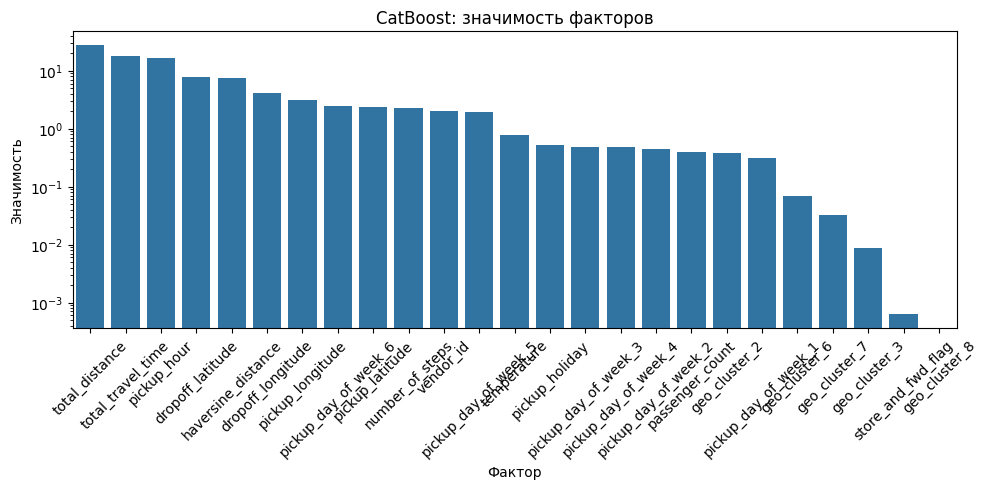

Топ-3 признака: ['total_distance' 'total_travel_time' 'pickup_hour']


In [46]:
importances = cat_model.feature_importances_
features = X_train_scaled_df.columns

df = pd.DataFrame({'Фактор': features, 'Значимость': importances})
df = df.sort_values('Значимость', ascending=False)

plt.figure(figsize=(10,5))
ax = sns.barplot(x='Фактор', y='Значимость', data=df)
ax.set_yscale('log')
plt.xticks(rotation=45)
plt.title('CatBoost: значимость факторов')
plt.tight_layout()
plt.show()

print("Топ-3 признака:", df['Фактор'].values[:3])

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MedAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [50]:
medae_seconds = metrics.median_absolute_error(y_val_orig, y_val_predict)
medae_minutes = medae_seconds / 60

print(f'Медианная абсолютная ошибка: {medae_seconds:.1f} сек ({medae_minutes:.1f} мин)')

Медианная абсолютная ошибка: 114.8 сек (1.9 мин)
